In [ ]:
"""
Treat categorical variables

"""

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Load data
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')

In [5]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,25.0,50-99,unknown,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,5,47,0
2,11561,city_21,0.624,unknown,No relevent experience,Full time course,Graduate,STEM,5.0,50-99,unknown,0,83,0
3,33241,city_115,0.789,unknown,No relevent experience,unknown,Graduate,Business Degree,0.5,50-99,Pvt Ltd,0,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,25.0,50-99,Funded Startup,4,8,0


### 1. Use 'gender' as feature

In [176]:
# Pick categorical variables
cat_variables = ['gender']
X_train_cat = df_train[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [178]:
columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,gender_Male,gender_Other,gender_unknown
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


In [179]:
# Repeat for test set
X_test_cat = df_test[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_test_cat) 
cats = ohe.transform(X_test_cat)

X_test_cat_df = pd.DataFrame(cats, columns=columns, index=X_test_cat.index)
X_test_cat_df.head()

,gender_Male,gender_Other,gender_unknown
0,1.0,0.0,0.0
1,0.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [180]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(X_train_cat_df, df_train['target'])
print('intercept: ', round(lm_1.intercept_[0], 4))
print('gender coef: ', round(lm_1.coef_[0][0], 4))

intercept:  -1.0287
gender coef:  -0.1919


In [181]:
# Using default threshold (=0.5)
df_eval = df_test.copy()
df_eval['pred'] = lm_1.predict(X_test_cat_df)
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['target']

In [182]:
pd.DataFrame(confusion_matrix(df_eval['target'], df_eval['pred']),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1553,0
Changing (1),576,0


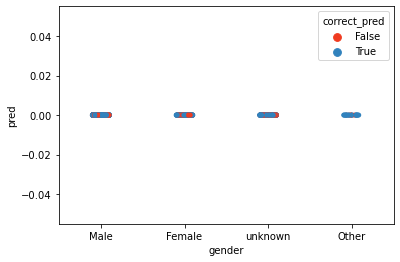

In [183]:
# Everyone's predicted to be not changing
sns.stripplot(data=df_eval,
              x='gender',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

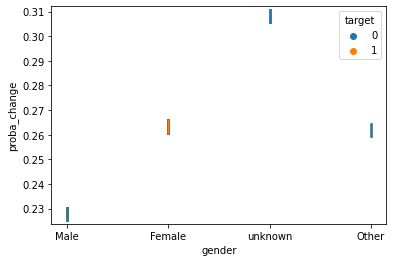

In [184]:
df_eval['proba_change'] = lm_1.predict_proba(X_test_cat_df)[:, 1]
sns.scatterplot(data=df_eval,
                x='gender',
                y='proba_change',
                hue='target',
                marker='|',
                s=200);

In [185]:
# Threshold = 0.24
df_eval = df_test.copy()
df_eval['pred'] = (lm_1.predict_proba(X_test_cat_df)[:, 1] >= 0.24)
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['target']

In [186]:
preds_low_th = (lm_1.predict_proba(X_test_cat_df)[:, 1] >= 0.23)

# Threshold = 0.25
pd.DataFrame(confusion_matrix(df_test['target'], preds_low_th),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1097,456
Changing (1),363,213


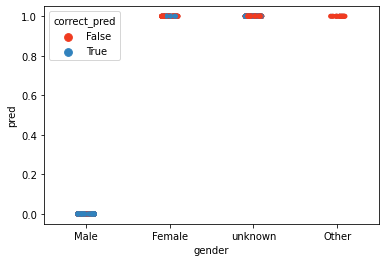

In [187]:
sns.stripplot(data=df_eval,
              x='gender',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [ ]:
# Conclusion: gender is not a good feature for prediction

#### Evaluate

### 2. Use 'relevent_experience	' as feature

In [112]:
df_train.relevent_experience.unique()

array(['Has relevent experience', 'No relevent experience'], dtype=object)

In [113]:
# Pick categorical variables
cat_variables = ['relevent_experience']
X_train_cat = df_train[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [114]:
columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,relevent_experience_No relevent experience
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0


In [115]:
# Repeat for test set
X_test_cat = df_test[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_test_cat) 
cats = ohe.transform(X_test_cat)

X_test_cat_df = pd.DataFrame(cats, columns=columns, index=X_test_cat.index)
X_test_cat_df.head()

,relevent_experience_No relevent experience
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [117]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(X_train_cat_df, df_train['target'])
print('intercept: ', round(lm_1.intercept_[0], 4))
print('relevent_experience coef: ', round(lm_1.coef_[0][0], 4))

intercept:  -1.2969
relevent_experience coef:  0.6266


In [118]:
# Using default threshold (=0.5)
df_eval = df_test.copy()
df_eval['pred'] = lm_1.predict(X_test_cat_df)
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['target']

In [119]:
pd.DataFrame(confusion_matrix(df_eval['target'], df_eval['pred']),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1553,0
Changing (1),576,0


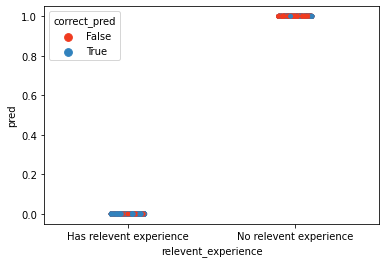

In [125]:
# Everyone's predicted to be not changing
sns.stripplot(data=df_eval,
              x='relevent_experience',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

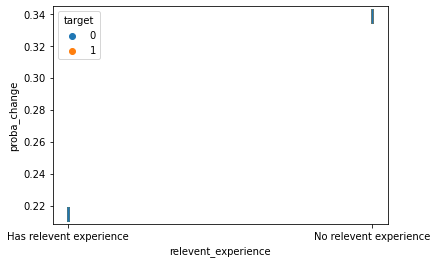

In [127]:
df_eval['proba_change'] = lm_1.predict_proba(X_test_cat_df)[:, 1]
sns.scatterplot(data=df_eval,
                x='relevent_experience',
                y='proba_change',
                hue='target',
                marker='|',
                s=200);

In [129]:
# Threshold = 0.24
df_eval = df_test.copy()
df_eval['pred'] = (lm_1.predict_proba(X_test_cat_df)[:, 1] >= 0.32)
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['target']

In [142]:
preds_low_th = (lm_1.predict_proba(X_test_cat_df)[:, 1] >= 0.2)

# Threshold = 0.25
pd.DataFrame(confusion_matrix(df_test['target'], preds_low_th),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),0,1553
Changing (1),0,576


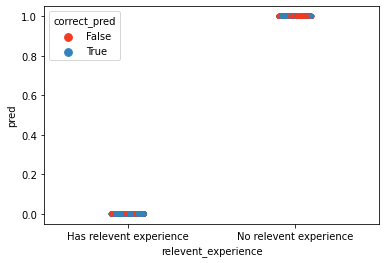

In [135]:
sns.stripplot(data=df_eval,
              x='relevent_experience',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [ ]:
# Conclusion: relevent_experience alone is not a good feature for prediction

### 3. Use 'major_discipline' as feature

In [143]:
df_train.major_discipline.unique()

array(['STEM', 'Business Degree', 'unknown', 'Arts', 'Humanities',
       'No Major', 'Other'], dtype=object)

In [144]:
# Pick categorical variables
cat_variables = ['major_discipline']
X_train_cat = df_train[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [145]:
columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,major_discipline_unknown
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0


In [146]:
# Repeat for test set
X_test_cat = df_test[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_test_cat) 
cats = ohe.transform(X_test_cat)

X_test_cat_df = pd.DataFrame(cats, columns=columns, index=X_test_cat.index)
X_test_cat_df.head()

,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,major_discipline_unknown
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0


In [147]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(X_train_cat_df, df_train['target'])
print('intercept: ', round(lm_1.intercept_[0], 4))
print('gender coef: ', round(lm_1.coef_[0][0], 4))

intercept:  -1.328
gender coef:  0.2976


In [148]:
# Using default threshold (=0.5)
df_eval = df_test.copy()
df_eval['pred'] = lm_1.predict(X_test_cat_df)
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['target']

In [149]:
pd.DataFrame(confusion_matrix(df_eval['target'], df_eval['pred']),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1553,0
Changing (1),576,0


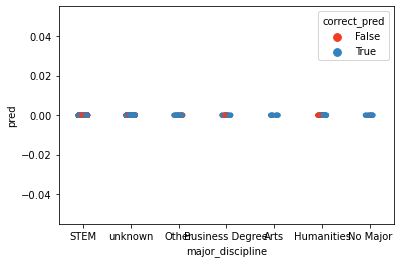

In [150]:
# Everyone's predicted to be not changing
sns.stripplot(data=df_eval,
              x='major_discipline',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

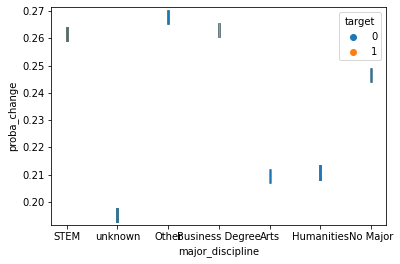

In [151]:
df_eval['proba_change'] = lm_1.predict_proba(X_test_cat_df)[:, 1]
sns.scatterplot(data=df_eval,
                x='major_discipline',
                y='proba_change',
                hue='target',
                marker='|',
                s=200);

In [152]:
# Threshold = 0.24
df_eval = df_test.copy()
df_eval['pred'] = (lm_1.predict_proba(X_test_cat_df)[:, 1] >= 0.24)
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['target']

In [173]:
preds_low_th = (lm_1.predict_proba(X_test_cat_df)[:, 1] >= 0.2)

# Threshold = 0.25
pd.DataFrame(confusion_matrix(df_test['target'], preds_low_th),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),240,1313
Changing (1),72,504


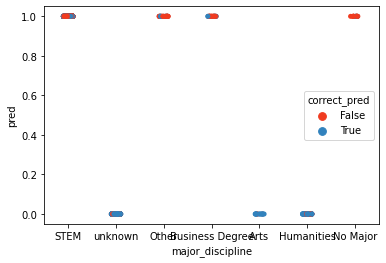

In [174]:
sns.stripplot(data=df_eval,
              x='major_discipline',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [189]:
# Conclusion: major_discipline alone is not a good feature for prediction

### 4. Use all categorical variables as features

In [193]:
# Pick categorical variables
cat_variables = ['relevent_experience','enrolled_university','education_level','major_discipline','company_size','company_type']
X_train_cat = df_train[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [194]:
columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,enrolled_university_unknown,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,education_level_unknown,major_discipline_Business Degree,...,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_unknown
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [195]:
# Repeat for test set
X_test_cat = df_test[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_test_cat) 
cats = ohe.transform(X_test_cat)

X_test_cat_df = pd.DataFrame(cats, columns=columns, index=X_test_cat.index)
X_test_cat_df.head()

,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,enrolled_university_unknown,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,education_level_unknown,major_discipline_Business Degree,...,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [223]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(X_train_cat_df, df_train['target'])
print('intercept: ', round(lm_1.intercept_[0], 4))
pd.DataFrame(list(zip(cat_variables,np.transpose(lm_1.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  -0.79


,Feature,Coef
0,relevent_experience,[0.28300841926621856]
3,major_discipline,[-0.20977913258039466]
5,company_type,[-0.25666045409661864]
1,enrolled_university,[-0.37379061832929233]
2,education_level,[-0.5117829004493679]
4,company_size,[-1.2021706508277556]


In [224]:
# Using default threshold (=0.5)
df_eval = df_test.copy()
df_eval['pred'] = lm_1.predict(X_test_cat_df)
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['target']

In [225]:
pd.DataFrame(confusion_matrix(df_eval['target'], df_eval['pred']),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1503,50
Changing (1),494,82


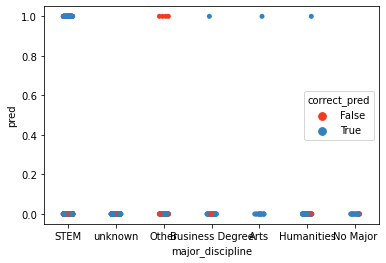

In [226]:
# Everyone's predicted to be not changing
sns.stripplot(data=df_eval,
              x='major_discipline',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

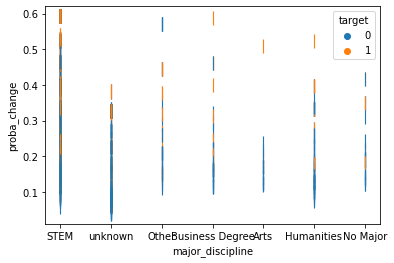

In [227]:
df_eval['proba_change'] = lm_1.predict_proba(X_test_cat_df)[:, 1]
sns.scatterplot(data=df_eval,
                x='major_discipline',
                y='proba_change',
                hue='target',
                marker='|',
                s=200);

In [244]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test_cat_df)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(df_eval['target'], y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Looking', 'Looking'],
           yticklabels=['Not Looking', 'Looking']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [245]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm_1, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [246]:
# Try lower threshold values
preds_low_th = (lm_1.predict_proba(X_test_cat_df)[:, 1] >= 0.18)

# Threshold = 0.25
pd.DataFrame(confusion_matrix(df_test['target'], preds_low_th),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),669,884
Changing (1),130,446


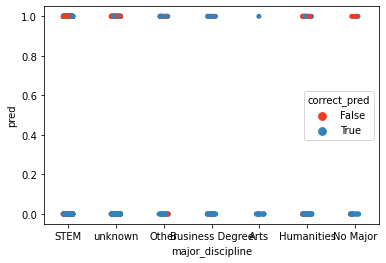

In [232]:
sns.stripplot(data=df_eval,
              x='major_discipline',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [189]:
# Conclusion: 